---

### Şimdi tam somut görelim:

* Tek kanal, 15×15 bir giriş alacağız

* Ortasına tek bir pikseli 1 yapacağız (geri kalan sıfır)

Aynı input’u:

* Normal 3×3 conv

* Dilated 3×3 (dilation=3) conv

ile işleyeceğiz


----

In [1]:
import torch
import torch.nn as nn

In [11]:
import torch
import torch.nn as nn

# 1) Input oluştur: tek bir piksel 1, diğerleri 0
x = torch.zeros(1, 1, 15, 15)   # (N=1, C=1, H=15, W=15)
x[0, 0, 7, 7] = 1.0             # ortadaki pikseli 1 yap

# 2) Normal 3x3 conv ve dilated 3x3 conv tanımla
conv_normal = nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    stride=1,
    padding=2,   # dilation=1 için H,W sabit kalsın diye
    dilation=2,
    bias=False
)

conv_dilated = nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    stride=1,
    padding=3,   # dilation=3 için effective kernel=7 -> padding=3
    dilation=3,
    bias=False
)

# 3) Ağırlıkları 1 yap (receptive field'i net görmek için)
with torch.no_grad():
    conv_normal.weight[:] = 1.0
    conv_dilated.weight[:] = 1.0

# 4) İleri geçiş
y_norm = conv_normal(x)
y_dil  = conv_dilated(x)

print("Girdi shape        :", x.shape)
print("Normal conv shape  :", y_norm.shape)
print("Dilated conv shape :", y_dil.shape)

# 5) Non-zero bölgeleri inceleyelim
print("\\nNormal conv çıktısı (merkez etrafı):")
print(y_norm[0, 0, 6:9, 6:9])   # 3x3 bölge

print("\\nDilated conv çıktısı (merkez etrafı daha geniş):")
print(y_dil[0, 0, 4:11, 4:11])  # 7x7 bölge

# 6) Gerçekten kaç piksel non-zero çıkmış görelim
print("\\nNormal conv non-zero sayısı:", (y_norm[0, 0] != 0).sum().item())
print("Dilated conv non-zero sayısı :", (y_dil[0, 0] != 0).sum().item())

Girdi shape        : torch.Size([1, 1, 15, 15])
Normal conv shape  : torch.Size([1, 1, 15, 15])
Dilated conv shape : torch.Size([1, 1, 15, 15])
\nNormal conv çıktısı (merkez etrafı):
tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]], grad_fn=<SliceBackward0>)
\nDilated conv çıktısı (merkez etrafı daha geniş):
tensor([[1., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 1.]], grad_fn=<SliceBackward0>)
\nNormal conv non-zero sayısı: 9
Dilated conv non-zero sayısı : 9


### Ne göreceğiz?

**Normal conv:**

* Non-zero bölge 3×3 olacak

* Ortadaki 1 pikselin etrafında 3×3’lük kare

**Dilated conv (dilation=3):**

* Non-zero bölge 7×7 olacak

* Yani 3×3 kernel, d=3 ile 7×7’lik alanı tarıyor

**Ve dikkat et:**

* Parametre sayısı her ikisinde de 9 (3×3×1×1)

* Feature map boyutu aynı (15×15, padding’i düzgün ayarladık)

* Sadece hangi pikselin hangi piksellere bağlandığı değişti (receptive field farkı).

---
---

---
---

## Amaç: 3 katmanlı normal CNN vs 3 katmanlı dilated CNN’in impulse’a verdiği tepkiyi görselleştirmek.

* Girdi: ortasında 1 olan 65×65 tek kanallı görüntü

* Model A: 3×3, dilation=1,1,1

* Model B: 3×3, dilation=1,2,4 (paddingleri ayarlı)

* Tüm ağırlıklar = 1, bias = 0 (sadece receptive field şekli görülsün)

* Çıktıyı matplotlib ile heatmap olarak çiziyoruz.




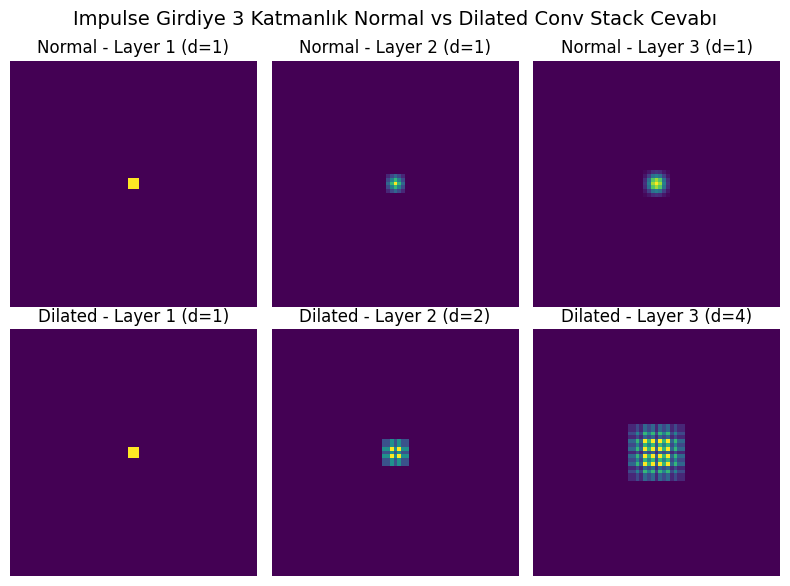

=== Normal Stack non-zero piksel sayıları ===
Layer 1: 9
Layer 2: 25
Layer 3: 49

=== Dilated Stack non-zero piksel sayıları ===
Layer 1: 9
Layer 2: 49
Layer 3: 225


In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def make_impulse_image(size=65, value=1.0):
    x = torch.zeros(1, 1, size, size)
    c = size // 2
    x[0, 0, c, c] = value
    return x


def set_all_weights_to_one(module: nn.Module):
    with torch.no_grad():
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                m.weight[:] = 1.0
                if m.bias is not None:
                    m.bias.zero_()

class NormalStack(nn.Module):
    def __init__(self, channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, dilation=1, bias=False)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, dilation=1, bias=False)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, dilation=1, bias=False)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        return x1, x2, x3


class DilatedStack(nn.Module):
    def __init__(self, channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, dilation=1, bias=False)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=2, dilation=2, bias=False)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=3, padding=4, dilation=4, bias=False)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        return x1, x2, x3


normal_model = NormalStack(channels=1)
dilated_model = DilatedStack(channels=1)

set_all_weights_to_one(normal_model)
set_all_weights_to_one(dilated_model)


x = make_impulse_image(size=65, value=1.0)  # (1,1,65,65)

n1, n2, n3 = normal_model(x)  
d1, d2, d3 = dilated_model(x)  

n1_np = n1[0, 0].detach().numpy()
n2_np = n2[0, 0].detach().numpy()
n3_np = n3[0, 0].detach().numpy()

d1_np = d1[0, 0].detach().numpy()
d2_np = d2[0, 0].detach().numpy()
d3_np = d3[0, 0].detach().numpy()


fig, axes = plt.subplots(2, 3, figsize=(8, 6))

# Normal katmanlar
axes[0, 0].imshow(n1_np)
axes[0, 0].set_title("Normal - Layer 1 (d=1)")
axes[0, 1].imshow(n2_np)
axes[0, 1].set_title("Normal - Layer 2 (d=1)")
axes[0, 2].imshow(n3_np)
axes[0, 2].set_title("Normal - Layer 3 (d=1)")

# Dilated katmanlar
axes[1, 0].imshow(d1_np)
axes[1, 0].set_title("Dilated - Layer 1 (d=1)")
axes[1, 1].imshow(d2_np)
axes[1, 1].set_title("Dilated - Layer 2 (d=2)")
axes[1, 2].imshow(d3_np)
axes[1, 2].set_title("Dilated - Layer 3 (d=4)")

for ax in axes.ravel():
    ax.axis("off")

plt.suptitle("Impulse Girdiye 3 Katmanlık Normal vs Dilated Conv Stack Cevabı", fontsize=14)
plt.tight_layout()
plt.show()


def count_non_zero(tensor):
    return int((tensor != 0).sum().item())

print("=== Normal Stack non-zero piksel sayıları ===")
print("Layer 1:", count_non_zero(n1[0, 0]))
print("Layer 2:", count_non_zero(n2[0, 0]))
print("Layer 3:", count_non_zero(n3[0, 0]))

print("\n=== Dilated Stack non-zero piksel sayıları ===")
print("Layer 1:", count_non_zero(d1[0, 0]))
print("Layer 2:", count_non_zero(d2[0, 0]))
print("Layer 3:", count_non_zero(d3[0, 0]))


---
---
---

### Yine impulse girdi kullanacağız ama bu sefer:

* 3 katmanlı NormalStack vs DilatedStack

Sadece heatmap değil:

* Son katmanın orta satırındaki değerleri alıp 1D line plot çizeceğiz (profil kesiti)

* Merkezi etrafındaki küçük patch’leri ayrıca zoom’layacağız

* Parametre sayıları + non-zero sayıları yine konsola yazılacak.

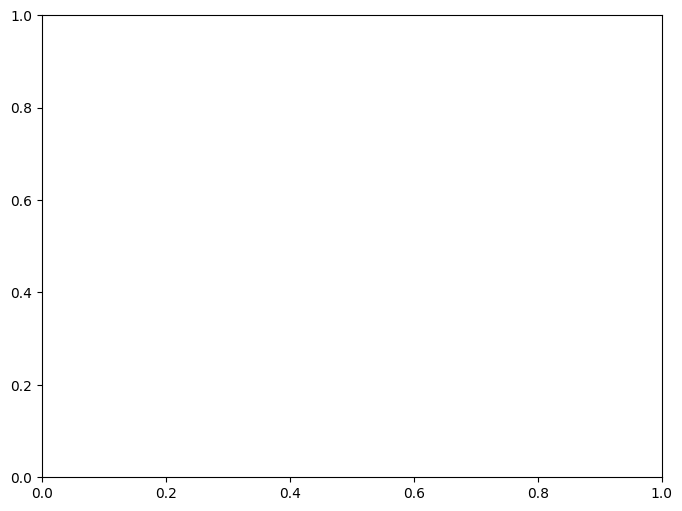

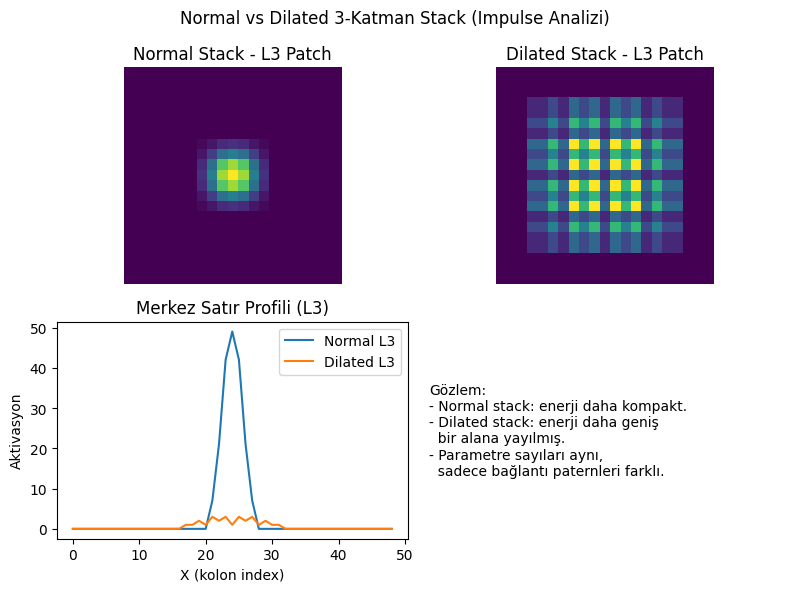

=== Parametre Sayıları ===
NormalStack toplam parametre: 27
  conv1: 9
  conv2: 9
  conv3: 9

DilatedStack toplam parametre: 27
  conv1: 9
  conv2: 9
  conv3: 9

=== Normal Stack non-zero piksel sayıları (L1-L2-L3) ===
L1: 9
L2: 25
L3: 49

=== Dilated Stack non-zero piksel sayıları (L1-L2-L3) ===
L1: 9
L2: 49
L3: 225


In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def make_impulse_image(size=49, value=1.0):
    x = torch.zeros(1, 1, size, size)
    c = size // 2
    x[0, 0, c, c] = value
    return x


def set_all_weights_to_one(module: nn.Module):
    with torch.no_grad():
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                m.weight[:] = 1.0
                if m.bias is not None:
                    m.bias.zero_()


def count_params(m: nn.Module):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


def count_non_zero(tensor: torch.Tensor):
    return int((tensor != 0).sum().item())

class NormalStack(nn.Module):
    def __init__(self, channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, dilation=1, bias=False)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, dilation=1, bias=False)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, dilation=1, bias=False)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        return x1, x2, x3


class DilatedStack(nn.Module):
    def __init__(self, channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, dilation=1, bias=False)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=2, dilation=2, bias=False)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=3, padding=4, dilation=4, bias=False)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        return x1, x2, x3

normal_model = NormalStack(channels=1)
dilated_model = DilatedStack(channels=1)

set_all_weights_to_one(normal_model)
set_all_weights_to_one(dilated_model)

x = make_impulse_image(size=49, value=1.0)  # (1,1,49,49)
H = W = x.shape[-1]
center = H // 2

n1, n2, n3 = normal_model(x)   
d1, d2, d3 = dilated_model(x)  

n3_np = n3[0, 0].detach().numpy()
d3_np = d3[0, 0].detach().numpy()


normal_center_line = n3_np[center, :]   
dilated_center_line = d3_np[center, :]

patch_radius = 10 
r0 = center - patch_radius
r1 = center + patch_radius + 1

normal_patch = n3_np[r0:r1, r0:r1]
dilated_patch = d3_np[r0:r1, r0:r1]

fig = plt.subplots(figsize=(8, 6))[1]
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

axes[0, 0].imshow(normal_patch)
axes[0, 0].set_title("Normal Stack - L3 Patch")
axes[0, 0].axis("off")

axes[0, 1].imshow(dilated_patch)
axes[0, 1].set_title("Dilated Stack - L3 Patch")
axes[0, 1].axis("off")

axes[1, 0].plot(normal_center_line, label="Normal L3")
axes[1, 0].plot(dilated_center_line, label="Dilated L3")
axes[1, 0].set_title("Merkez Satır Profili (L3)")
axes[1, 0].set_xlabel("X (kolon index)")
axes[1, 0].set_ylabel("Aktivasyon")
axes[1, 0].legend()

axes[1, 1].axis("off")
axes[1, 1].text(
    0.0, 0.5,
    "Gözlem:\n"
    "- Normal stack: enerji daha kompakt.\n"
    "- Dilated stack: enerji daha geniş\n"
    "  bir alana yayılmış.\n"
    "- Parametre sayıları aynı,\n"
    "  sadece bağlantı paternleri farklı.",
    transform=axes[1, 1].transAxes,
    va="center"
)

plt.suptitle("Normal vs Dilated 3-Katman Stack (Impulse Analizi)", fontsize=12)
plt.tight_layout()
plt.show()

print("=== Parametre Sayıları ===")
print("NormalStack toplam parametre:", count_params(normal_model))
print("  conv1:", count_params(normal_model.conv1))
print("  conv2:", count_params(normal_model.conv2))
print("  conv3:", count_params(normal_model.conv3))

print("\nDilatedStack toplam parametre:", count_params(dilated_model))
print("  conv1:", count_params(dilated_model.conv1))
print("  conv2:", count_params(dilated_model.conv2))
print("  conv3:", count_params(dilated_model.conv3))

print("\n=== Normal Stack non-zero piksel sayıları (L1-L2-L3) ===")
print("L1:", count_non_zero(n1[0, 0]))
print("L2:", count_non_zero(n2[0, 0]))
print("L3:", count_non_zero(n3[0, 0]))

print("\n=== Dilated Stack non-zero piksel sayıları (L1-L2-L3) ===")
print("L1:", count_non_zero(d1[0, 0]))
print("L2:", count_non_zero(d2[0, 0]))
print("L3:", count_non_zero(d3[0, 0]))
